In [49]:
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set your dataset paths
original_dataset_dir = r"C:\Users\Priyamvadha Pradeep\Desktop\DL Mid Model\horse-or-human"
base_dir = r'C:\Users\Priyamvadha Pradeep\Desktop\DL Mid Model\processed_data'

Train horses: 400
Train humans: 421
Test horses: 100
Test humans: 106


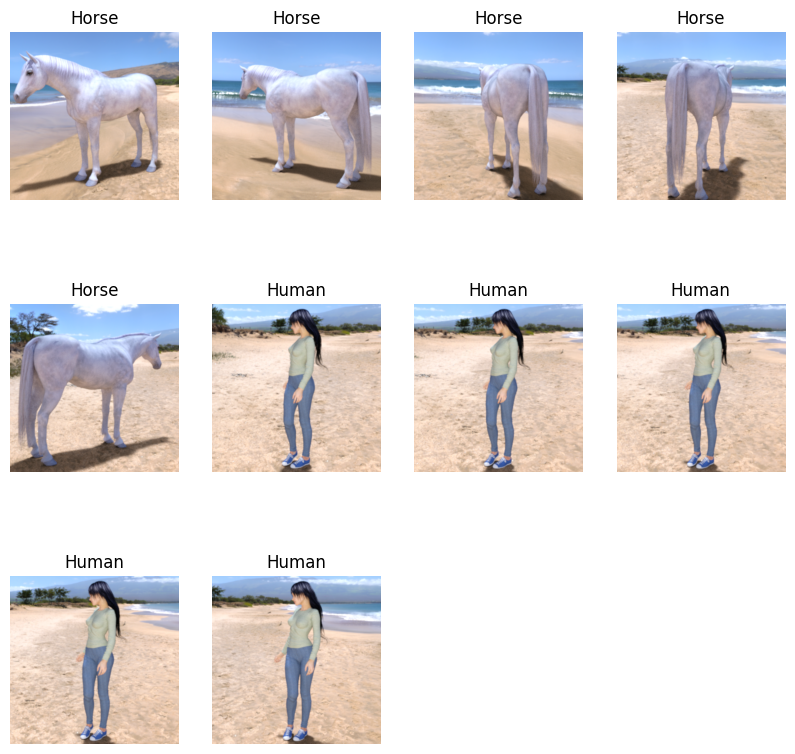

In [50]:
# Define paths for the processed training and testing datasets
train_horses_dir = os.path.join(base_dir, 'train', 'horses')
train_humans_dir = os.path.join(base_dir, 'train', 'humans')
test_horses_dir = os.path.join(base_dir, 'test', 'horses')
test_humans_dir = os.path.join(base_dir, 'test', 'humans')

# Create directories for training and testing datasets
os.makedirs(train_horses_dir, exist_ok=True)
os.makedirs(train_humans_dir, exist_ok=True)
os.makedirs(test_horses_dir, exist_ok=True)
os.makedirs(test_humans_dir, exist_ok=True)

# Function to load and split images into training and testing sets
def load_and_split_images():
    for category in ['horses', 'humans']:
        # Set the path to the category folder
        category_path = os.path.join(original_dataset_dir, category)
        
        # Check if the category path exists
        if not os.path.exists(category_path):
            print(f"Directory not found: {category_path}")
            continue  # Skip to the next category if path doesn't exist
        
        # Load images in the category directory
        images = os.listdir(category_path)
        
        # Check if images are found in the directory
        if not images:
            print(f"No images found in the directory: {category_path}")
            continue

        # Split into 80% train and 20% test
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Define destination folders based on category
        train_dir = train_horses_dir if category == 'horses' else train_humans_dir
        test_dir = test_horses_dir if category == 'horses' else test_humans_dir

        # Move images to corresponding directories
        for img in train_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(train_dir, img)
            shutil.copy(src, dst)  # Use copy to keep original files in place
        
        for img in test_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(test_dir, img)
            shutil.copy(src, dst)  # Use copy to keep original files in place

# Run the function to split and organize the images
load_and_split_images()

# Verify the count of images in each split
print("Train horses:", len(os.listdir(train_horses_dir)))
print("Train humans:", len(os.listdir(train_humans_dir)))
print("Test horses:", len(os.listdir(test_horses_dir)))
print("Test humans:", len(os.listdir(test_humans_dir)))

# Visualization function for a few samples
def visualize_samples():
    sample_images = []
    sample_labels = []
    # Collect a few images from each class for visualization
    for img in os.listdir(train_horses_dir)[:5]:
        sample_images.append(os.path.join(train_horses_dir, img))
        sample_labels.append("Horse")
    for img in os.listdir(train_humans_dir)[:5]:
        sample_images.append(os.path.join(train_humans_dir, img))
        sample_labels.append("Human")
    
    plt.figure(figsize=(10, 10))
    for i in range(len(sample_images)):
        img = plt.imread(sample_images[i])
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(sample_labels[i])
        plt.axis('off')
    plt.show()

# Run visualization to confirm the images are correctly labeled
visualize_samples()


In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Set up paths for the training and test directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [52]:
# Data Preprocessing: Image augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images in batches for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Set shuffle to False for correct evaluation
)

Found 821 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


In [53]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10


c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - accuracy: 0.5871 - loss: 0.7059 - val_accuracy: 0.8490 - val_loss: 0.3736
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.4991 - val_accuracy: 1.0000 - val_loss: 0.0417
Epoch 3/10


c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 439ms/step - accuracy: 0.7445 - loss: 0.5030 - val_accuracy: 0.9271 - val_loss: 0.1724
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.5575 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.8543 - loss: 0.3436 - val_accuracy: 0.9323 - val_loss: 0.1789
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7812 - loss: 0.3948 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - accuracy: 0.8764 - loss: 0.2916 - val_accuracy: 0.9792 - val_loss: 0.0606
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.4065 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step - accuracy: 0.8754 - loss: 0.2781 - val_accuracy: 0.9323 - val_loss: 0.1480
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2723 - val_accuracy: 1.0000 - val_los

In [55]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.9795 - loss: 0.0800
Test Accuracy: 97.40%
Test Loss: 0.0819
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


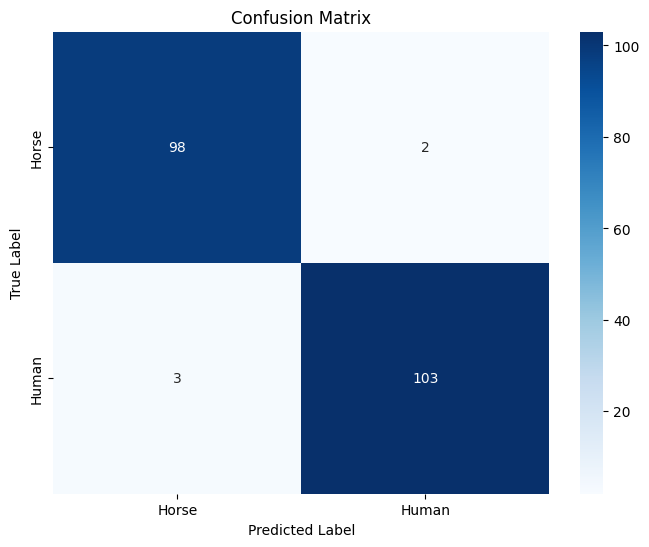

Classification Report:
              precision    recall  f1-score   support

       Horse       0.97      0.98      0.98       100
       Human       0.98      0.97      0.98       106

    accuracy                           0.98       206
   macro avg       0.98      0.98      0.98       206
weighted avg       0.98      0.98      0.98       206



In [56]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Horse', 'Human'], yticklabels=['Horse', 'Human'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Horse', 'Human']))

In [61]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,983,813 (60.97 MB)

 Trainable params: 5,327,937 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,655,876 (40.65 MB)